In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#download the dataset for the dog-breed identification challenge https://www.kaggle.com/c/dog-breed-identification
!kaggle competitions download -c dog-breed-identification

#unzip the downloaded files
from zipfile import ZipFile
zip_files = ["labels.csv.zip", "test.zip" ,"train.zip"]
for files in zip_files:
    with ZipFile(files, "r") as zips:
        zips.extractall()
print("All Files Extracted")

In [0]:
#import the neccesary packages
import pandas as pd
import numpy as np

#constants
num_classes = 12 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32

#Read the csv into a dataframe, group the breeds and 
df = pd.read_csv('labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()

total number of breeds to classify 12


,id,breed,filename
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,train/003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,train/0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,train/00693b8bc2470375cc744a6391d397ec.jpg
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,train/0162b3e0144fb1d1ab82fbff3ace9938.jpg


In [1]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

Using TensorFlow backend.


## <u>Label Encoding</u>
### The Breeds Of the Dogs Comes as the String or Names. So In Order to Feed the Labels into the Neural Network, We are Converting the Breed names into Numeric Characters

In [0]:
from sklearn.preprocessing import LabelEncoder
#Declaring the Instance
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
#This returns an Array of Boolean
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9

#Here We are Encoding and Spliting the Data into Testing and Training Set.
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [0]:
from tqdm import tqdm
#Importing the Pretrained Neural Network(For Transfer Learning)
from keras.applications import xception

#Creating Placeholder for Image Array(Training and Validation Images With 3 Colour Channels i.e Depth)
x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    #Reading the Image using Pre-Processing Function Created Before
    img = read_img(img_id, 'train', (im_size, im_size))
    #Here We are Normalizing the Image. It Takes the Numpy Array of Image and Converts into the Format that 
    #Xception Neural Network Reocgs i.e. Value Between [-1,1]
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    #Block Execuites If Array Contains True(Bool)
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
        #Adding It To the Training Set
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1355it [00:06, 200.99it/s]

Train Images shape: (1218, 299, 299, 3) size: 326,671,254


## Image Augmentation(Real Time)
### This Technique Will Increase Image Size, Involving Creating a New Image By Transformation(Rotation, Scaling, Noise). This Helps in Effective Training Of the Neural Network(CNN)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

#Declaring the Class For Image Augmentation Process(Options are Parameters)
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#Generating the Image From Fectures Declared
train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)


## Transfer Learning And Model Declaration
### We Are Using <u>Xception</u> Pre-Trained Model For Our Task

In [0]:
#Declaring the Neural Network model
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
#We are Not Including the Weights of Last Layer(Modifying)
base_model = xception.Xception(weights='imagenet', include_top=False)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer and set it to the number of breeds we want to classifiy, 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

83689472/83683744 [==============================] - 3s 0us/step


In [0]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
learning_rate = 0.001

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

#Saving Our Trained Model
bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)



# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_idx.sum() // batch_size,
                           epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                           validation_data=valid_generator,
                           validation_steps=valid_idx.sum() // batch_size)

# serialize weights to HDF5
model.save(bst_model_path)
print("Saved model to disk")

Epoch 1/10
38/38 [==============================] - 40s 1s/step - loss: 0.5477 - acc: 0.8281 - val_loss: 0.0555 - val_acc: 0.9766

Epoch 00001: val_loss improved from inf to 0.05554, saving model to 2018-11-21_dog_breed_model.h5
Epoch 2/10
38/38 [==============================] - 29s 759ms/step - loss: 0.3135 - acc: 0.8876 - val_loss: 0.0263 - val_acc: 0.9905

Epoch 00002: val_loss improved from 0.05554 to 0.02626, saving model to 2018-11-21_dog_breed_model.h5
Epoch 3/10
38/38 [==============================] - 32s 836ms/step - loss: 0.3134 - acc: 0.9065 - val_loss: 0.0391 - val_acc: 0.9905

Epoch 00003: val_loss did not improve from 0.02626
Epoch 4/10
38/38 [==============================] - 32s 853ms/step - loss: 0.3213 - acc: 0.8986 - val_loss: 0.0187 - val_acc: 0.9905

Epoch 00004: val_loss improved from 0.02626 to 0.01871, saving model to 2018-11-21_dog_breed_model.h5
Epoch 5/10
38/38 [==============================] - 32s 852ms/step - loss: 0.2478 - acc: 0.9106 - val_loss: 0.0113

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


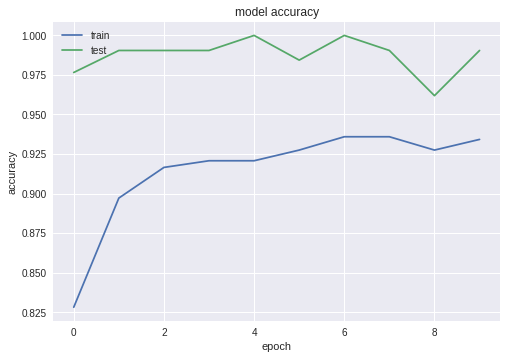

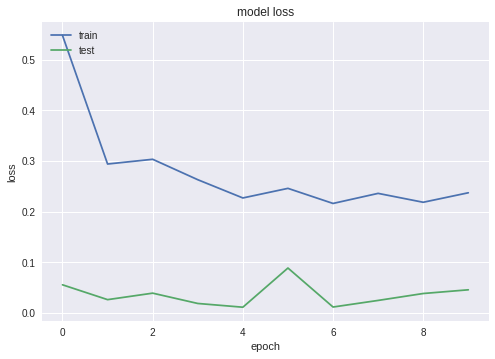

In [0]:
import matplotlib.pyplot as plt
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


#This Function is For Pre-Processing the Image For Feeding into Neural Network
def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class, max(pred)

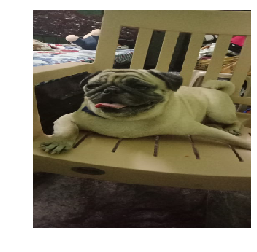

pug
1.0394377341071959e-06


In [9]:
#Getting Image From URL
#!wget http://www.dogbreedslist.info/uploads/allimg/dog-pictures/Scottish-Deerhound-2.jpg

#Testing This With My Own Pug Dog Image Taken In Phone
img_path = 'puggy.jpeg'    # dog
classes, prob = predict_from_image(img_path)
print(f"{classes}\n{prob[selected_breed_list.index(classes)]}")

## Server


In [3]:
from keras.models import load_model
model = load_model('2019-04-12_dog_breed_model.h5')
# predict_from_image("https://scontent.xx.fbcdn.net/v/t1.0-0/p480x480/46450986_347833089130675_1126767133754130432_n.jpg?_nc_cat=111&_nc_ht=scontent.xx&oh=9a149438b2243510e3b8d16921e575bc&oe=5C6FA5C1")


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
# import urllib.request 

# urllib.request.urlretrieve("https://scontent.xx.fbcdn.net/v/t1.0-0/p480x480/46450986_347833089130675_1126767133754130432_n.jpg?_nc_cat=111&_nc_ht=scontent.xx&oh=9a149438b2243510e3b8d16921e575bc&oe=5C6FA5C1", "image.jpg")
# predict_from_image("image.jpg")
import requests
f = open('00000001.jpg','wb')
f.write(requests.get('URL').content)
f.close()

In [6]:
selected_breed_list = ['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'leonberg',
 'cairn',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'blenheim_spaniel',
 'miniature_pinscher',
 'irish_wolfhound',
 'lakeland_terrier',
 'saluki',
 'papillon',
 'whippet',
 'siberian_husky',
 'norwegian_elkhound',
 'pug',
 'chow',
 'italian_greyhound',
 'pembroke',
 'ibizan_hound',
 'border_terrier',
 'newfoundland',
 'lhasa',
 'silky_terrier',
 'bedlington_terrier',
 'dandie_dinmont',
 'irish_setter',
 'sealyham_terrier',
 'rhodesian_ridgeback',
 'old_english_sheepdog',
 'collie',
 'boston_bull',
 'english_foxhound',
 'bouvier_des_flandres',
 'african_hunting_dog',
 'schipperke',
 'kelpie',
 'weimaraner',
 'bloodhound',
 'bluetick',
 'saint_bernard',
 'labrador_retriever',
 'chesapeake_bay_retriever',
 'norfolk_terrier',
 'english_setter',
 'wire-haired_fox_terrier',
 'kerry_blue_terrier',
 'scotch_terrier',
 'yorkshire_terrier',
 'groenendael',
 'greater_swiss_mountain_dog',
 'irish_terrier',
 'basset',
 'keeshond',
 'west_highland_white_terrier',
 'gordon_setter',
 'malamute',
 'affenpinscher',
 'toy_poodle']